In [1]:
import requests
import json
import time
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi,voronoi_plot_2d
from shapely.geometry import Polygon
%matplotlib inline

In [3]:
stations = pd.read_csv('isd-history.csv',parse_dates=['BEGIN','END'])
stations['station_id'] = stations.apply(lambda x: str(x['USAF'])+str(x['WBAN']), axis=1)
stations = stations.set_index('station_id')
stations.head()

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
station_id,,,,,,,,,,,
702699999,7026,99999,WXPOD 7026,AF,NaN,NaN,0.0,0.0,7026.0,2014-07-11,2017-08-22
707099999,7070,99999,WXPOD 7070,AF,NaN,NaN,0.0,0.0,7070.0,2014-09-23,2015-09-26
840399999,8403,99999,XM10,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-01,2014-04-12
841199999,8411,99999,XM20,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-02,2016-02-17
841499999,8414,99999,XM18,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-01,2016-02-17


In [4]:
utah_stations = stations[stations.STATE == 'UT']
utah_stations.head()

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
station_id,,,,,,,,,,,
69133499999,691334,99999,HILL/WENDOVER R GWC,US,UT,KQSL,41.050,-113.067,1299.0,1991-05-21,2003-08-16
69430099999,694300,99999,EAGLE RANGE &,US,UT,NaN,41.050,-113.067,1292.0,1980-04-23,1991-06-26
72056599999,720565,99999,HEBER CITY MUNICIPAL AIRPORT,US,UT,K36U,40.482,-111.429,1718.2,2010-04-12,2018-01-30
72056724180,720567,24180,BRIGHAM CITY AIRPORT,US,UT,KBMC,41.552,-112.062,1288.1,2014-07-24,2018-01-31
72056999999,720569,99999,KANAB MUNI,US,UT,KKNB,37.011,-112.531,1483.8,2013-08-13,2017-08-19


C:\Users\dani9510\AppData\Local\ESRI\conda\envs\venv\lib\site-packages\scipy\spatial\_plotutils.py:20: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  was_held = ax.ishold()


,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
station_id,,,,,,,,,,,
72470093141,724700,93141,CARBON COUNTY AIRPORT,US,UT,KPUC,39.609,-110.755,1804.7,2006-01-01,2018-01-31
72472099999,724720,99999,BLANDING,US,UT,NaN,37.617,-109.467,1840.0,1973-01-01,2018-01-29
72472393025,724723,93025,BLANDING MUNI,US,UT,K4BL,37.583,-109.483,1789.0,1990-02-08,2010-06-21
72473523170,724735,23170,HANKSVILLE,US,UT,KHVE,38.371,-110.715,1354.5,1973-01-01,2018-01-31
72475099999,724750,99999,MILFORD MUNICIPAL,US,UT,KMLF,38.417,-113.017,1536.0,1973-01-01,2018-01-15


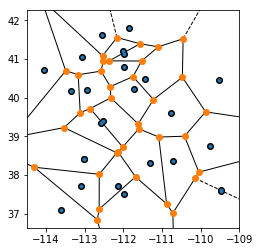

In [6]:
# Let's get stations that are valid for all of our time range. Not perfect, but I'd rather not deal with missing data for now
start = pd.Timestamp(2010,1,1)
valid_stations = utah_stations[(utah_stations.BEGIN < start) & (utah_stations.END > start)]
plt.figure()

lons = valid_stations.LON.values
lats = valid_stations.LAT.values
plt.plot(lons, lats,'ko')


vor = Voronoi(np.vstack((lons,lats)).T)
voronoi_plot_2d(vor,ax=plt.gca())
plt.gca().set_aspect(1)
valid_stations.head()

In [7]:
stations = valid_stations.index.values.tolist()
print(stations)
valid_stations.to_csv('utah_stations.csv')

['72470093141', '72472099999', '72472393025', '72473523170', '72475099999', '72475423186', '72475593129', '72475623159', '72477693075', '72479599999', '72479694128', '72479723176', '72570594030', '72572024127', '72572424174', '72575024126', '72575399999', '72575524101', '72581024193', '74003024103', '9999993081', '9999994133', '9999994134', '9999994138', '99999923162', '99999953149']


In [15]:
url = 'https://www.ncdc.noaa.gov/access-data-service/api/v1/data'

params = {
    'dataset': 'global-hourly',
    'startDate': '2018-02-02T00:00:00',
    'endDate': '2018-02-22T17:00:00',
    'dataTypes':'AA1,AA1,AA2,AA3,TMP,VIS,WND,AJ1,AT1,AT2,AT3,AT4,AT5,AT6,AT7,AT8',
    'stations': stations,
    'format': 'json'
    
}

params['stations'] = ','.join(stations)
res = requests.get(url,params=params)

In [17]:
res.json()[-1]

{'DATE': '2018-02-21T06:35:00',
 'QUALITY_CONTROL': 'V020',
 'REPORT_TYPE': 'FM-15',
 'SOURCE': '6',
 'STATION': '99999923162',
 'TMP': '-0150,5',
 'VIS': '016093,5,N,5',
 'WND': '999,9,C,0000,5'}

In [8]:
url = 'https://www.ncdc.noaa.gov/access-data-service/api/v1/data'

params = {
    'dataset': 'global-hourly',
    'startDate': '2010-01-01T00:00:00',
    'endDate': '2018-02-01T00:00:00',
    'dataTypes':'AA1,AA1,AA2,AA3,TMP,VIS,WND,AJ1,AT1,AT2,AT3,AT4,AT5,AT6,AT7,AT8',
    'stations': stations,
    'format': 'json'
    
}

weather_data = pd.DataFrame()

for station in stations:
    params['stations'] = station
    print('Station:',station)
    res = requests.get(url,params=params)
    js = res.json()
    #print(js)
    print(len(js))
    try:
        weather_data = weather_data.append(js)
    except:
        print ("Empty for station",station)
    time.sleep(0.5)


Station: 72056599999
39021
Station: 72056724180
90980
Station: 72056999999
3


C:\Users\dani9510\AppData\Local\ESRI\conda\envs\venv\lib\site-packages\pandas\core\frame.py:5186: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  other = other.loc[:, self.columns]
C:\Users\dani9510\AppData\Local\ESRI\conda\envs\venv\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Station: 72057299999
66886
Station: 72092299999
23556
Station: 72470093141
82095
Station: 72472099999
6351
Station: 72472393025
3
Station: 72473323170
47098
Station: 72473523170
84478
Station: 72475023176
16485
Station: 72475099999
42168
Station: 72475423186
164113
Station: 72475593129
84393
Station: 72475623159
92246
Station: 72477693075
80793
Station: 72479599999
6760
Station: 72479694128
92932
Station: 72479723176
98930
Station: 72570594030
84736
Station: 72572024127
107223
Station: 72572424174
125742
Station: 72575024126
86423
Station: 72575399999
24930
Station: 72575524101
117983
Station: 72581024193
186734
Station: 74003024103
7227
Station: 999999480
0
Empty for station 999999480
Station: 999999481
0
Empty for station 999999481
Station: 9999993081
0
Empty for station 9999993081
Station: 9999994133
0
Empty for station 9999994133
Station: 9999994134
0
Empty for station 9999994134
Station: 9999994138
0
Empty for station 9999994138
Station: 9999994143
0
Empty for station 9999994143
S

In [9]:
weather_data.head()
weather_data.to_csv('utah_weather_2010-2018_raw.csv')

In [10]:

def parseWindDir(x):
    # Wind direction, deg or 999
    d = x.split(',')[0]
    if d == '999':
        return np.nan
    return float(d)


def parseWindSpeed(x):
    s = x.split(',')[3]
    if s == '9999':
        return 0.0
    return float(s) / 10.0

def parseVisibility(x):
    v = x.split(',')[0]
    if v == '999999':
        return 16093.0
    return float(v)

def parseTemp(x):
    t = x.split(',')[0]
    if t == '+9999':
        return np.nan
    return float(t) / 10.0

def parseSnowDepth(x):
    try:
        t = x.split(',')[0]
    except:
        return 0.0

    if t == '9999':
        return 0.0
    return float(t) 

def parsePrecip(x):
    try:
        p = x.split(',')[1]
        return float(p) / 10.0
    except:
        return 0.0

weather_lut = {
    '01': 'fog',
    '02': 'fog',
    '03': 'thunder',
    '04': 'sleet/hail',
    '05': 'hail',
    '06': 'glaze',
    '07': 'dust',
    '08': 'smoke',
    '09': 'blowing_snow',
    '10': 'tornado',
    '11': 'winds',
    '12': 'spray',
    '13': 'mist',
    '14': 'drizzle',
    '15': 'freezing_drizzle',
    '16': 'rain',
    '17': 'freezing_rain',
    '18': 'snow',
    '19': 'unknown_precipitation',
    '21': 'ground_fog',
    '22': 'ice_fog'
}
def parseWeatherType(x):
    try:
        p = x.split(',')[1]
    except:
        return x
    return weather_lut[p]
        
    
weather_data['DATE'] = pd.to_datetime(weather_data["DATE"])
weather_data['wind_dir'] = weather_data.WND.apply(parseWindDir)
weather_data['wind_speed'] = weather_data.WND.apply(parseWindSpeed)
weather_data['visibility'] = weather_data.VIS.apply(parseVisibility)
weather_data['temperature'] = weather_data.TMP.apply(parseTemp)
weather_data['precip_01'] = weather_data.AA1.apply(parsePrecip)
weather_data['precip_02'] = weather_data.AA2.apply(parsePrecip)
weather_data['precip_03'] = weather_data.AA3.apply(parsePrecip)
weather_data['precip_depth'] = weather_data[['precip_01','precip_02','precip_03']].max(axis=1)
weather_data['snow_depth'] = weather_data.AJ1.apply(parseSnowDepth)
weather_data['AT1'] = weather_data.AT1.apply(parseWeatherType)
weather_data['AT2'] = weather_data.AT2.apply(parseWeatherType)
weather_data['AT3'] = weather_data.AT3.apply(parseWeatherType)
weather_data['AT4'] = weather_data.AT4.apply(parseWeatherType)
weather_data['AT5'] = weather_data.AT5.apply(parseWeatherType)
weather_data['AT6'] = weather_data.AT6.apply(parseWeatherType)
weather_data['AT7'] = weather_data.AT7.apply(parseWeatherType)
weather_data['AT8'] = weather_data.AT8.apply(parseWeatherType)

weather_types = weather_data[['AT1','AT2','AT3','AT4','AT5','AT6','AT7','AT8']]

weather_data['snowing'] = weather_types.apply(lambda x: x.isin(['snow'])).any(axis=1)
weather_data['raining'] = weather_types.apply(lambda x: x.isin(['rain','freezing_rain','drizzle','freezing_drizzle'])).any(axis=1)
weather_data['foggy'] = weather_types.apply(lambda x: x.isin(['fog','ground_fog','ice_fog'])).any(axis=1)
weather_data['thunderstorm'] = weather_types.apply(lambda x: x.str.contains('thunder')).any(axis=1)
weather_data['hailing'] = weather_types.apply(lambda x: x.isin(['sleet/hail','hail'])).any(axis=1)
weather_data['icy'] = weather_types.apply(lambda x: x.isin(['glaze','freezing_rain,freezing_drizzle','ice_fog','snow'])).any(axis=1)
weather_data['station_id'] = weather_data.STATION

# Drop parsed columns
weather_data = weather_data.drop(['WND','VIS','AA1','AA2','AA3','precip_01','precip_02','precip_03','AJ1'],axis=1)
weather_data = weather_data.drop(['TMP','AT1','AT2','AT3','AT4','AT5','AT6','AT7','AT8','SOURCE','REPORT_TYPE','QUALITY_CONTROL','STATION'],axis=1)

In [11]:
weather_data.head()

,DATE,wind_dir,wind_speed,visibility,temperature,precip_depth,snow_depth,snowing,raining,foggy,thunderstorm,hailing,icy,station_id
0,2010-04-12 18:35:00,150.0,10.3,16093.0,17.0,0.0,0.0,False,False,False,False,False,False,72056599999
1,2010-04-12 19:00:00,140.0,8.7,16093.0,16.0,0.0,0.0,False,False,False,False,False,False,72056599999
2,2010-04-12 19:14:00,180.0,5.7,16093.0,16.0,0.0,0.0,False,False,False,False,False,False,72056599999
3,2010-04-12 19:35:00,180.0,5.1,16093.0,15.0,0.0,0.0,False,False,False,False,False,False,72056599999
4,2010-04-12 19:54:00,180.0,3.6,16093.0,16.0,0.0,0.0,False,False,False,False,False,False,72056599999


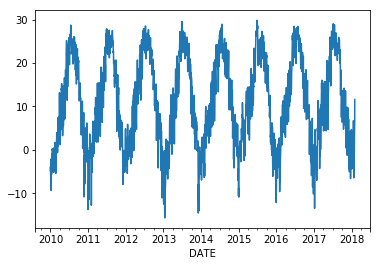

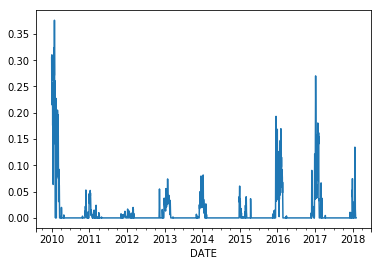

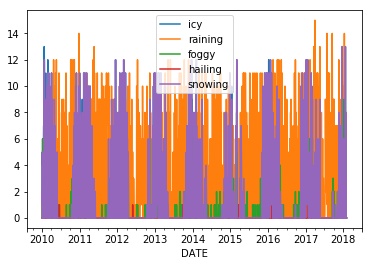

In [12]:
ts = weather_data.set_index('DATE').temperature.resample('1d').mean()
ts.plot()
ts = weather_data.set_index('DATE').snow_depth.resample('1d').mean()
plt.figure()
ts.plot()
ts = weather_data.set_index('DATE')[['icy','raining','foggy','hailing','snowing']].resample('1d').sum()
plt.figure()
ts.plot()

In [3]:
#weather_data.to_csv('utah_weather_2010-2018.csv')
weather_data = pd.read_csv('utah_weather_2010-2018.csv',index_col=0)
weather_data.head()

C:\Users\dani9510\AppData\Local\ESRI\conda\envs\venv\lib\site-packages\numpy\lib\arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,DATE,wind_dir,wind_speed,visibility,temperature,precip_depth,snow_depth,snowing,raining,foggy,thunderstorm,hailing,icy,station_id
0,2010-01-01 00:53:00,40.0,2.1,16093.0,-11.7,0.0,0.0,False,False,False,False,False,False,72470093141
1,2010-01-01 01:53:00,30.0,2.6,16093.0,-11.7,0.0,0.0,False,False,False,False,False,False,72470093141
2,2010-01-01 02:53:00,40.0,2.1,16093.0,-12.2,0.0,0.0,False,False,False,False,False,False,72470093141
3,2010-01-01 03:53:00,40.0,2.6,16093.0,-11.7,0.0,0.0,False,False,False,False,False,False,72470093141
4,2010-01-01 04:53:00,40.0,2.1,16093.0,-9.4,0.0,0.0,False,False,False,False,False,False,72470093141


In [4]:
weather_data['timestamp'] = pd.to_datetime(weather_data.DATE)

In [5]:
time_index = pd.DatetimeIndex(weather_data['timestamp'])

In [50]:
aggs = {
    'snowing': 'any',
    'raining': 'any',
    'foggy': 'any',
    'icy': 'any',
    'hailing': 'any',
    'thunderstorm':'any',
    'wind_speed': 'mean',
    'visibility': 'mean',
    'temperature': 'mean',
    'precip_depth':'mean',
    'snow_depth':'mean'
}

In [60]:
resamp = pd.DataFrame()
for _id in station_ids:
    idx = weather_data.station_id == _id
    ti = time_index[idx]

    wdfi = weather_data[idx].set_index(ti)
    floating = wdfi[['visibility','temperature','wind_speed','precip_depth','snow_depth']]
    binaries = wdfi[['snowing','raining','foggy','icy','hailing','thunderstorm']]
    b = binaries.resample('1h').rolling(24).apply(lambda x: x.any())
    f = floating.resample('1h').agg({
        'wind_speed': 'mean',
        'visibility': 'mean',
        'temperature': 'mean',
        'precip_depth':'mean',
        'snow_depth':'mean'
    })

    temp = pd.concat((f,b),axis=1)
    temp['station_id'] = _id
    resamp = resamp.append(temp)


C:\Users\dani9510\AppData\Local\ESRI\conda\envs\venv\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
.resample() is now a deferred operation
You called rolling(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  if __name__ == '__main__':


In [61]:
for f in ['visibility','temperature','wind_speed','precip_depth','snow_depth']:
    resamp.loc[pd.isna(resamp[f]),f] = np.nanmedian(resamp[f])
for f in ['snowing','raining','foggy','icy','hailing','thunderstorm']:
    resamp.loc[pd.isna(resamp[f]),f] = 0

In [71]:
resamp.reset_index().set_index(['timestamp','station_id']).to_csv('utah_weather_2010-2018_grouped.csv')

In [18]:
if False:
    t = time.time()
    resamp = weather_data.set_index(['station_id',time_index.floor('1h')]).groupby(level=[0,1]).agg(aggs)
    print (time.time() - t)

1218.8045225143433


In [19]:
if False: resamp.to_csv('utah_weather_2010-2018_grouped.csv')

In [24]:
samps = resamp.reset_index().set_index('timestamp')

In [36]:
#samps[samps.snowing == True]
samps['2016-01-06T06:00:00'].to_csv('test_hour.csv')